In [5]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

/Users/fredshone/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Predicting Bike Checkout - With Weather Forecast
Training of a variety of models for predicting bike checkouts (currently set up for three hours into the future). In this workbook it is assumed that weather data is known up to and including the time of prediction (ie it is assumed that there is good forecast data)
#### Methodology
Three years of data are used for training and validation. There is currently no test. Intention is to wait for new data. 2015 and 2016 data is used for training. 2017 data is used for validation. This is a large validation set but provides validation against a wide variety of seasonal variation.
Data is standardised to mean of zero and single standard deviation.
Mean Absolute Error is used to compare senarios.

          -------time---------------------------------------->
          
raw data------------------1---1---1---0---2---1---4---1---4---4---6---5---2---2---1---0---0---1--

          
known data---------------1---1---1---0---2---1---4---1---4---4---6---5---2---2-----------------

          
unknown data------------1---1---1---0---2---1---4---1---4-------------------------------

          -------time---------------------------------------->
                ^                          ^              ^
                |                          |              |
                |   <----lookback----->    |  <--delay--> |
                |   <------------known data-------------> |
                |   <--unknown data--->    |              |
                |                          |              |
                                time of prediction    prediction
#### Benchmarking
Two simple benchmarks are created: prediction using previous day and prediction using previos same-day. MAEs are around 0.3 standard deviations - approx. ten checkout counts.
#### Results
A simple fully connected model offers no improvement over the benchmarks.
A number of recurrent networks (GRU and LSTM) are trained - best validation MAE is approx. 0.17 standard deviations or six checkout counts.
#### Notes
Better performance is achieved with heavier models with larger, more complex and more layers, but improvements are minor.
Need to try different periods of lookback.

In [1]:
def standardise(_array):
    array = _array.copy()
    mean = array.mean(axis=0)
    array -= mean
    std = array.std(axis=0)
    array /= std
    return array

In [2]:
def split(df):
    y = np.array(df['Checkout_count'],
                 dtype='float64')
    Xk = np.array(df[['month', 'weekday', 'hour',
                      'Holiday', 'Teaching_term', 'Study_Holidays', 'Exam_Period', 'Holidays_Period',
                      'rain', 'temp', 'humidity', 'wind_speed', 'visibility', 'cloud_amount']],
                  dtype='float64')
    Xu = np.array(df[['Checkout_count']],
                  dtype='float64')
    return Xk, Xu, y   

In [3]:
def generator(_y, _Xk, _Xu, lookback, delay, batch_size=128, step=1):
    """Method to generate batches of """
    max_index = len(_y) - delay - 1
    i = lookback - 1
    while True:
        end_index = min(i + batch_size, max_index)       
        rows = np.arange(i, end_index)
        length = len(rows)     
        #print('{}-->{} ({})'.format(i, end_index, length))          
        i += length        
        if i >= max_index:
            #print('> all data seen')
            i = lookback    
        y = np.zeros((len(rows),))
        Xk = np.zeros((len(rows),
                      (lookback + delay) // step,
                      _Xk.shape[-1]))
        Xu = np.zeros((len(rows),
                       (lookback + delay) // step,
                       _Xu.shape[-1]))
        for j, row in enumerate(rows):
            y[j] = _y[rows[j] + delay]
            known_indices = range(rows[j] - lookback, rows[j] + delay, step)
            Xk[j] = _Xk[known_indices]
            unknown_indices = range(rows[j] - lookback, rows[j], step)
            Xu[j,:(lookback//step)] = _Xu[unknown_indices]
        X = np.concatenate((Xu, Xk), axis=2)
            
        yield X, y    

In [6]:
df_raw = pd.read_csv(os.path.join('data', 'bike_share_hours.csv'))
df = df_raw.drop('date', axis=1)

In [7]:
mean = df.mean(axis=0)
std = df.std(axis=0)
df_standardised = standardise(df)

In [8]:
lookback = 7 * 24
delay = 3
step = 1
batch_size = 128

In [9]:
df_standardised.describe()

,Unnamed: 0,year,month,day,weekday,week,hour,Checkout_count,rain,temp,humidity,wind_speed,wind_direction,visibility,cloud_amount,Holiday,Teaching_term,Study_Holidays,Exam_Period,Holidays_Period
count,2.629800e+04,2.629800e+04,2.629800e+04,2.629800e+04,2.629800e+04,2.629800e+04,2.629800e+04,2.629800e+04,2.629800e+04,2.629800e+04,2.629800e+04,2.629800e+04,2.629800e+04,2.629800e+04,2.629800e+04,2.629800e+04,2.629800e+04,2.629800e+04,2.629800e+04,2.629800e+04
mean,1.729209e-17,-1.729209e-17,8.646044e-17,5.619929e-17,-1.567096e-17,-5.187627e-17,1.293529e-17,-4.214947e-17,6.377538e-15,2.718749e-14,-3.761029e-16,3.296304e-17,8.646044e-17,3.458418e-17,-7.943553e-17,9.834875e-17,1.902130e-16,-4.971476e-17,1.383367e-16,8.646044e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.731952e+00,-1.225211e+00,-1.600997e+00,-1.673982e+00,-1.502986e+00,-1.708021e+00,-1.661831e+00,-9.968580e-01,-2.618729e-01,-2.876356e+00,-4.745870e+00,-1.886504e+00,-2.598461e+00,-1.720343e+00,-2.436319e+00,-1.677740e-01,-8.973755e-01,-1.706274e-01,-2.749181e-01,-8.976517e-01
25%,-8.659760e-01,-1.225211e+00,-7.311898e-01,-8.786095e-01,-1.002866e+00,-8.453565e-01,-7.949608e-01,-8.801305e-01,-2.618729e-01,-6.895556e-01,-5.246522e-01,-7.188683e-01,-6.638192e-01,-5.164802e-01,-7.393280e-01,-1.677740e-01,-8.973755e-01,-1.706274e-01,-2.749181e-01,-8.976517e-01
50%,0.000000e+00,0.000000e+00,1.386175e-01,3.038716e-02,-2.624407e-03,1.730758e-02,7.190957e-02,-2.381290e-01,-2.618729e-01,8.640569e-02,2.351670e-01,-1.350505e-01,1.825865e-01,8.847620e-02,5.334151e-01,-1.677740e-01,-8.973755e-01,-1.706274e-01,-2.749181e-01,-8.976517e-01
75%,8.659760e-01,1.225211e+00,1.008425e+00,8.257592e-01,9.976168e-01,8.799717e-01,9.387800e-01,5.497819e-01,-2.618729e-01,7.212832e-01,8.261376e-01,6.433732e-01,7.871619e-01,6.934326e-01,5.334151e-01,-1.677740e-01,1.114318e+00,-1.706274e-01,-2.749181e-01,1.113975e+00
max,1.731952e+00,1.225211e+00,1.588296e+00,1.734756e+00,1.497737e+00,1.742636e+00,1.661172e+00,5.014610e+00,2.648694e+01,3.284307e+00,1.079411e+00,6.481551e+00,1.754483e+00,2.810780e+00,9.576628e-01,5.960172e+00,1.114318e+00,5.860501e+00,3.637309e+00,1.113975e+00


In [10]:
df_train = df_standardised[(df.year == 2015) | (df.year == 2016)]
len(df_train)

17539

In [11]:
df_validate = df_standardised[df.year == 2017]
len(df_validate)

8759

In [12]:
Xk_train, Xu_train, y_train = split(df_train)
Xk_validate, Xu_validate, y_validate = split(df_validate)

In [13]:
lookback = 7 * 24
delay = 0
step = 1
batch_size = 128

In [14]:
training_gen = generator(y_train, Xk_train, Xu_train,
                         lookback, delay)
num_training_batches = int((len(df_train) - lookback - delay) / batch_size)
validation_gen = generator(y_validate, Xk_validate, Xu_validate,
                         lookback, delay)
num_validation_samples = int((len(df_validate) - lookback - delay) / batch_size)

## Benchmarking
Benchmarking with some relatively naive methods:
1. predicting using checkouts from 7 days ago
2. pedicting using checkouts from 24 hours ago

In [15]:
def eval_naive(samples, gen, index):
    maes = []
    for i in range(samples):
        X, y = next(gen)
        preds = X[:, index, 0]
        mae = np.mean(np.abs(preds - y))
        maes.append(mae)
    return np.mean(maes)

In [17]:
# Sample from 7 days ago
eval_naive(num_validation_samples, validation_gen, delay) * df.Checkout_count.std()

10.224315920397547

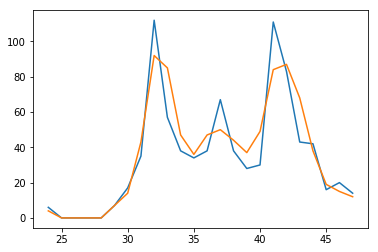

In [32]:
date = '2017-08-30'
sample = list(df_raw.index[df_raw.date == date])
actuals = [None] * len(sample)
preds = [None] * len(sample)
for index in sample:
    actual = df_raw.Checkout_count.iloc[(index)]
    pred = df_raw.Checkout_count.iloc[(index-(24*7))]
    actuals.append(actual)
    preds.append(pred)
plt.plot(actuals)
plt.plot(preds)    

In [33]:
# Sample from 1 day ago
eval_naive(num_validation_samples, validation_gen, -24) * df.Checkout_count.std()

13.08530006218846

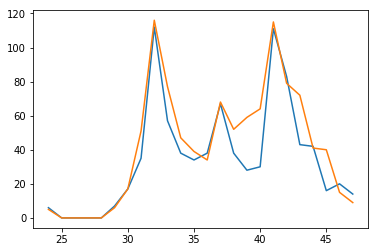

In [34]:
date = '2017-08-30'
sample = list(df_raw.index[df_raw.date == date])
actuals = [None] * len(sample)
preds = [None] * len(sample)
for index in sample:
    actual = df_raw.Checkout_count.iloc[(index)]
    pred = df_raw.Checkout_count.iloc[(index-24)]
    actuals.append(actual)
    preds.append(pred)
plt.plot(actuals)
plt.plot(preds)   

In [35]:
model = Sequential()
model.add(layers.Flatten(input_shape=((lookback + delay)// step, 15)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

In [36]:
model.compile(optimizer=RMSprop(),loss='mae')
hist = model.fit_generator(training_gen,
                          steps_per_epoch=500,
                          epochs = 20,
                          validation_data= validation_gen,
                          validation_steps=num_validation_samples)

Epoch 1/20
500/500 [==============================] - 11s 21ms/step - loss: 1.5890 - val_loss: 0.9964
Epoch 2/20
500/500 [==============================] - 9s 19ms/step - loss: 1.0019 - val_loss: 0.6459
Epoch 3/20
500/500 [==============================] - 9s 17ms/step - loss: 0.8234 - val_loss: 0.6868
Epoch 4/20
500/500 [==============================] - 9s 18ms/step - loss: 0.7614 - val_loss: 0.5836
Epoch 5/20
500/500 [==============================] - 9s 17ms/step - loss: 0.6515 - val_loss: 0.4570
Epoch 6/20
500/500 [==============================] - 9s 17ms/step - loss: 0.5877 - val_loss: 0.5710
Epoch 7/20
500/500 [==============================] - 9s 18ms/step - loss: 0.5665 - val_loss: 0.3978
Epoch 8/20
500/500 [==============================] - 9s 19ms/step - loss: 0.4996 - val_loss: 0.3801
Epoch 9/20
500/500 [==============================] - 9s 18ms/step - loss: 0.4931 - val_loss: 0.3737
Epoch 10/20
500/500 [==============================] - 9s 17ms/step - loss: 0.4794 - val_l

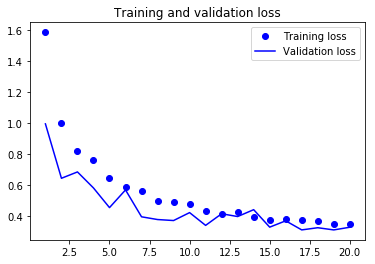

In [37]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [38]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, 15)))
model.add(layers.Dense(1))

In [39]:
model.compile(optimizer=RMSprop(),loss='mae')
hist = model.fit_generator(training_gen,
                          steps_per_epoch=500,
                          epochs = 20,
                          validation_data= validation_gen,
                          validation_steps=num_validation_samples)

Epoch 1/20
500/500 [==============================] - 71s 142ms/step - loss: 0.3446 - val_loss: 0.3168
Epoch 2/20
500/500 [==============================] - 66s 133ms/step - loss: 0.2866 - val_loss: 0.2869
Epoch 3/20
500/500 [==============================] - 66s 131ms/step - loss: 0.2594 - val_loss: 0.2865
Epoch 4/20
500/500 [==============================] - 66s 132ms/step - loss: 0.2415 - val_loss: 0.2614
Epoch 5/20
500/500 [==============================] - 57s 115ms/step - loss: 0.2199 - val_loss: 0.2138
Epoch 6/20
500/500 [==============================] - 56s 111ms/step - loss: 0.1950 - val_loss: 0.2133
Epoch 7/20
500/500 [==============================] - 55s 109ms/step - loss: 0.1823 - val_loss: 0.2037
Epoch 8/20
500/500 [==============================] - 55s 110ms/step - loss: 0.1786 - val_loss: 0.1912
Epoch 9/20
500/500 [==============================] - 55s 110ms/step - loss: 0.1736 - val_loss: 0.1996
Epoch 10/20
500/500 [==============================] - 54s 109ms/step - l

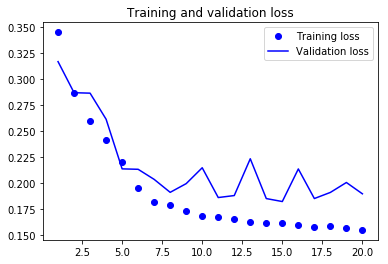

In [40]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [41]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, 15)))
model.add(layers.GRU(64, activation='relu',
                    dropout=0.1,
                    recurrent_dropout=0.5))
model.add(layers.Dense(1))

In [42]:
model.compile(optimizer=RMSprop(),loss='mae')
hist = model.fit_generator(training_gen,
                          steps_per_epoch=500,
                          epochs = 40,
                          validation_data= validation_gen,
                          validation_steps=num_validation_samples)

Epoch 1/40
500/500 [==============================] - 201s 403ms/step - loss: 0.4134 - val_loss: 0.3071
Epoch 2/40
500/500 [==============================] - 187s 374ms/step - loss: 0.3208 - val_loss: 0.2752
Epoch 3/40
500/500 [==============================] - 186s 371ms/step - loss: 0.2906 - val_loss: 0.2730
Epoch 4/40
500/500 [==============================] - 185s 370ms/step - loss: 0.2748 - val_loss: 0.2495
Epoch 5/40
500/500 [==============================] - 186s 373ms/step - loss: 0.2602 - val_loss: 0.2134
Epoch 6/40
500/500 [==============================] - 182s 364ms/step - loss: 0.2484 - val_loss: 0.2205
Epoch 7/40
500/500 [==============================] - 180s 360ms/step - loss: 0.2442 - val_loss: 0.2142
Epoch 8/40
500/500 [==============================] - 182s 364ms/step - loss: 0.2379 - val_loss: 0.2168
Epoch 9/40
500/500 [==============================] - 182s 364ms/step - loss: 0.2322 - val_loss: 0.2067
Epoch 10/40
500/500 [==============================] - 185s 371m

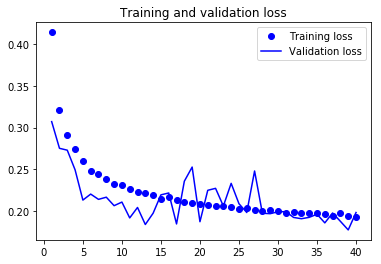

In [43]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [44]:
model = Sequential()
model.add(layers.LSTM(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, 15)))
model.add(layers.GRU(64, activation='relu',
                    dropout=0.1,
                    recurrent_dropout=0.5))
model.add(layers.Dense(1))

In [45]:
model.compile(optimizer=RMSprop(),loss='mae')
hist = model.fit_generator(training_gen,
                          steps_per_epoch=500,
                          epochs = 40,
                          validation_data= validation_gen,
                          validation_steps=num_validation_samples)

Epoch 1/40
500/500 [==============================] - 147s 295ms/step - loss: 0.4257 - val_loss: 0.3779
Epoch 2/40
500/500 [==============================] - 143s 286ms/step - loss: 0.3101 - val_loss: 0.2592
Epoch 3/40
500/500 [==============================] - 143s 287ms/step - loss: 0.2730 - val_loss: 0.3082
Epoch 4/40
500/500 [==============================] - 143s 286ms/step - loss: 0.2554 - val_loss: 0.2696
Epoch 5/40
500/500 [==============================] - 144s 288ms/step - loss: 0.2395 - val_loss: 0.2032
Epoch 6/40
500/500 [==============================] - 144s 288ms/step - loss: 0.2297 - val_loss: 0.2588
Epoch 7/40
500/500 [==============================] - 144s 287ms/step - loss: 0.2223 - val_loss: 0.2661
Epoch 8/40
500/500 [==============================] - 144s 287ms/step - loss: 0.2185 - val_loss: 0.1974
Epoch 9/40
500/500 [==============================] - 143s 287ms/step - loss: 0.2126 - val_loss: 0.2589
Epoch 10/40
500/500 [==============================] - 144s 287m

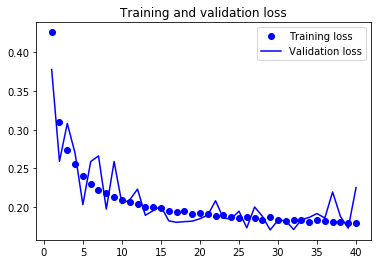

In [46]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [47]:
model = Sequential()
model.add(layers.LSTM(64,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, 15)))
model.add(layers.GRU(128, activation='relu',
                    dropout=0.1,
                    recurrent_dropout=0.5))
model.add(layers.Dense(1))

In [48]:
model.compile(optimizer=RMSprop(),loss='mae')
hist = model.fit_generator(training_gen,
                          steps_per_epoch=500,
                          epochs = 40,
                          validation_data= validation_gen,
                          validation_steps=num_validation_samples)

Epoch 1/40
500/500 [==============================] - 373s 746ms/step - loss: 0.3798 - val_loss: 0.2644
Epoch 2/40
500/500 [==============================] - 379s 758ms/step - loss: 0.2842 - val_loss: 0.2319
Epoch 3/40
500/500 [==============================] - 381s 763ms/step - loss: 0.2471 - val_loss: 0.2199
Epoch 4/40
500/500 [==============================] - 382s 764ms/step - loss: 0.2241 - val_loss: 0.2368
Epoch 5/40
500/500 [==============================] - 387s 775ms/step - loss: 0.2160 - val_loss: 0.1855
Epoch 6/40
500/500 [==============================] - 388s 776ms/step - loss: 0.2076 - val_loss: 0.2023
Epoch 7/40
500/500 [==============================] - 388s 775ms/step - loss: 0.2002 - val_loss: 0.1943
Epoch 8/40
500/500 [==============================] - 397s 793ms/step - loss: 0.1988 - val_loss: 0.2204
Epoch 9/40
500/500 [==============================] - 397s 793ms/step - loss: 0.1939 - val_loss: 0.1903
Epoch 10/40
500/500 [==============================] - 395s 789m

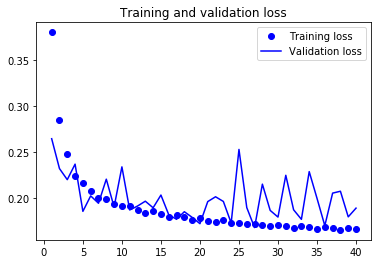

In [49]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [50]:
model = Sequential()
model.add(layers.LSTM(32,
                      input_shape=(None, 15)))
model.add(layers.Dense(1))

In [52]:
model.compile(optimizer=RMSprop(),loss='mae')
hist = model.fit_generator(training_gen,
                          steps_per_epoch=500,
                          epochs = 20,
                          validation_data= validation_gen,
                          validation_steps=num_validation_samples)

Epoch 1/20
500/500 [==============================] - 68s 135ms/step - loss: 0.2177 - val_loss: 0.2196
Epoch 2/20
500/500 [==============================] - 66s 132ms/step - loss: 0.1932 - val_loss: 0.2222
Epoch 3/20
500/500 [==============================] - 67s 133ms/step - loss: 0.1793 - val_loss: 0.1960
Epoch 4/20
500/500 [==============================] - 66s 131ms/step - loss: 0.1738 - val_loss: 0.1860
Epoch 5/20
500/500 [==============================] - 66s 133ms/step - loss: 0.1695 - val_loss: 0.2052
Epoch 6/20
500/500 [==============================] - 66s 131ms/step - loss: 0.1639 - val_loss: 0.1920
Epoch 7/20
500/500 [==============================] - 67s 134ms/step - loss: 0.1630 - val_loss: 0.1824
Epoch 8/20
500/500 [==============================] - 66s 132ms/step - loss: 0.1610 - val_loss: 0.1960
Epoch 9/20
500/500 [==============================] - 66s 133ms/step - loss: 0.1580 - val_loss: 0.1962
Epoch 10/20
500/500 [==============================] - 66s 133ms/step - l

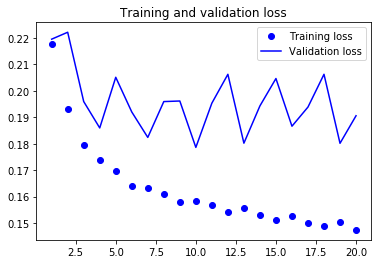

In [53]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()